#HW 10 CLUSTERING BUSINESS

#cluster time trends in NYC businesses: 
#DATA
#Census Business data:
##download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##and it can be downloaded by hand. you can also download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [ ]:
#$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done

#$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done

#$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done


#NYC zip codes shape file is here
##http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

## Step 1: get and prep data
### NOTE: Assumes zipcode geojson is in working folder

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mplleaflet as mpl
import os
import zipfile

%matplotlib inline

In [2]:
# read in NYC zipcodes
zipcodes = gpd.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')

# code for reproducibility - assume data in '/notebook/data/' folder:
# data_folder = os.getenv('PUI2015') + '/notebooks/data/'

In [3]:
# view zipcodes
#plt.figure(figsize=(14,14))
zipcodes.plot(figsize=(14,10))
mpl.display(crs=zipcodes.crs)

In [9]:
#zf = zipfile.ZipFile(fname)
#df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
#from os.path import isfile, join
filenames = [f for f in os.listdir('./') if os.path.isfile(f)]
filenames = [f for f in filenames if f.split('.')[1]=='zip']
print filenames

['zbp10totals.zip', 'zbp97totals.zip', 'zbp13totals.zip', 'zbp03totals.zip', 'zbp11totals.zip', 'zbp04totals.zip', 'zbp01totals.zip', 'zbp95totals.zip', 'zbp07totals.zip', 'zbp12totals.zip', 'zbp08totals.zip', 'zbp06totals.zip', 'zbp05totals.zip', 'zbp02totals.zip', 'zbp96totals.zip', 'zbp99totals.zip', 'zbp98totals.zip', 'zbp00totals.zip', 'zbp94totals.zip', 'zbp09totals.zip']


In [156]:
# zpb common value columns: "zip","name","empflag","emp","qp1","ap","est"
print filenames[12]
zf = zipfile.ZipFile(filenames[12])
df = pd.read_csv(zf.open(filenames[12].replace('.zip', '.txt')))
df.info()

zbp05totals.zip
<class 'pandas.core.frame.DataFrame'>
Int64Index: 39625 entries, 0 to 39624
Data columns (total 7 columns):
zip        39625 non-null int64
name       39625 non-null object
empflag    5536 non-null object
emp        39625 non-null int64
qp1        39625 non-null int64
ap         39625 non-null int64
est        39625 non-null int64
dtypes: int64(5), object(2)
memory usage: 2.4+ MB


In [157]:
print [x.lower() for x in df.columns.tolist()]

['zip', 'name', 'empflag', 'emp', 'qp1', 'ap', 'est']


In [158]:
%reset_selective df

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [4]:
# convert zipcode to integer as that's what pandas will automatically convert to
zipcodes['zipnum'] = zipcodes.postalCode.astype(int)

In [5]:
# get rid of some extraneous fields in zipcode data
zipcodes.drop(['@id', 'BLDGpostalCode', 'Shape_Leng', 'STATE', 'ST_FIPS'], inplace=True, axis=1)
zipcodes.head()

,CTY_FIPS,OBJECTID,PO_NAME,Shape_Area,borough,geometry,postalCode,zipnum
0,081,1,Jackson Heights,20163283.87440,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,11372
1,081,2,Glen Oaks,22606526.91390,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,11004
2,081,3,New Hyde Park,6269333.41234,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,11040
3,081,4,Bellerose,49418364.05770,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,11426
4,081,5,Fresh Meadows,69385865.59430,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,11365


In [6]:
# make column names lower case
old_col = zipcodes.columns.tolist()
new_col = [x.lower() for x in old_col]
col_names = dict(zip(old_col, new_col))
zipcodes.rename(columns=col_names, inplace=True)
zipcodes.head()

,cty_fips,objectid,po_name,shape_area,borough,geometry,postalcode,zipnum
0,081,1,Jackson Heights,20163283.87440,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,11372
1,081,2,Glen Oaks,22606526.91390,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,11004
2,081,3,New Hyde Park,6269333.41234,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,11040
3,081,4,Bellerose,49418364.05770,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,11426
4,081,5,Fresh Meadows,69385865.59430,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,11365


In [7]:
# read in all zip code data, select out only those that exist in NY zipcode data

def read_zpb(f):
    zf = zipfile.ZipFile(f)
    yr = '19' + f[3:5] if int(f[3:5]) > 90 else '20'+f[3:5]
    print "reading %s" % f
    tmp = pd.read_csv(zf.open(f.replace('.zip', '.txt')))
    old_col = tmp.columns.tolist()
    new_col = [x.lower() for x in old_col]
    col_names = dict(zip(old_col, new_col))
    tmp.rename(columns=col_names, inplace=True)
    tmp = pd.merge(zipcodes, tmp, how='left', left_on='zipnum', right_on='zip')
    tmp['year'] = yr
    return tmp

In [10]:
frames = [ read_zpb(f) for f in filenames ]
df = pd.concat(frames)
df.info()

reading zbp10totals.zip
reading zbp97totals.zip
reading zbp13totals.zip
reading zbp03totals.zip
reading zbp11totals.zip
reading zbp04totals.zip
reading zbp01totals.zip
reading zbp95totals.zip
reading zbp07totals.zip
reading zbp12totals.zip
reading zbp08totals.zip
reading zbp06totals.zip
reading zbp05totals.zip
reading zbp02totals.zip
reading zbp96totals.zip
reading zbp99totals.zip
reading zbp98totals.zip
reading zbp00totals.zip
reading zbp94totals.zip
reading zbp09totals.zip
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5240 entries, 0 to 261
Data columns (total 22 columns):
ap            5052 non-null float64
ap_nf         1771 non-null object
borough       5240 non-null object
city          1009 non-null object
cty_fips      5240 non-null object
cty_name      1009 non-null object
emp           5052 non-null float64
emp_nf        1771 non-null object
empflag       283 non-null object
est           5052 non-null float64
geometry      5240 non-null object
name          5052 

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (Ntimestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

In [11]:
# drop all the fields obviously not in many datasets
df.drop(['ap_nf', 'city', 'cty_name', 'emp_nf', 'empflag', 'qp1_nf', 'stabbr'], inplace=True, axis=1)
df.head()

,ap,borough,cty_fips,emp,est,geometry,name,objectid,po_name,postalcode,qp1,shape_area,year,zip,zipnum
0,232448,Queens,081,7676,1629,POLYGON ((-73.86942457284175 40.74915687096787...,"JACKSON HEIGHTS, NY",1,Jackson Heights,11372,53202,20163283.87440,2010,11372,11372
1,112122,Queens,081,2662,229,POLYGON ((-73.71068374074007 40.75004039450917...,"GLEN OAKS, NY",2,Glen Oaks,11004,27391,22606526.91390,2010,11004,11004
2,1203113,Queens,081,21724,1494,POLYGON ((-73.70098278625547 40.73889569923034...,"NEW HYDE PARK, NY",3,New Hyde Park,11040,275537,6269333.41234,2010,11040,11040
3,52068,Queens,081,1644,248,POLYGON ((-73.72270447144122 40.75373371438336...,"BELLEROSE, NY",4,Bellerose,11426,12110,49418364.05770,2010,11426,11426
4,313518,Queens,081,7173,643,POLYGON ((-73.81088634744755 40.72717187575918...,"FRESH MEADOWS, NY",5,Fresh Meadows,11365,74371,69385865.59430,2010,11365,11365


In [123]:
# data for clustering
est_data = df.groupby(['postalcode', 'year'])['est'].sum()
est_data.head()

postalcode  year
00083       1994   NaN
            1995   NaN
            1996   NaN
            1997   NaN
            1998   NaN
Name: est, dtype: float64

In [124]:
est_data = est_data.reset_index()

In [125]:
est_data = est_data.pivot(index='postalcode', columns='year', values='est')
est_data.shape

(247, 20)

In [126]:
est_data = est_data.iloc[1:,:] # drop central park
est_data.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
postalcode,,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,4460,4496,4532,4692,4704,4932,5176,4988,5012,5008,5132,5040,5244,5480,5504,5516,5592,5616,5768,5916
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296


IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



In [127]:
est_data.dropna(inplace=True)
clust_data = est_data.copy(deep=True)

In [128]:
clust_data.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
postalcode,,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,4460,4496,4532,4692,4704,4932,5176,4988,5012,5008,5132,5040,5244,5480,5504,5516,5592,5616,5768,5916
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296


In [129]:
# normalize so mean is ~0 and std is ~1
for yr in est_data.columns.tolist():
    clust_data.loc[:,yr] = (est_data[yr] - est_data[yr].mean()) / est_data[yr].std()

In [130]:
clust_data.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
postalcode,,,,,,,,,,,,,,,,,,,,
10001,5.172698,5.113754,5.081986,5.018998,5.045552,5.018452,4.976859,4.865905,4.966012,4.912585,4.984866,4.969245,5.005783,5.152881,5.100373,5.027621,4.955887,4.915699,4.854207,4.817438
10002,0.799345,0.796260,0.867200,0.935448,0.881498,0.940092,1.059528,1.263039,1.074073,1.171622,1.240593,1.348494,1.336876,1.345836,1.349302,1.429265,1.492093,1.508409,1.511176,1.506647
10003,2.033780,2.072908,2.091744,2.124117,2.186779,2.187050,2.152339,2.084446,2.150107,2.211933,2.192395,2.275187,2.285718,2.413437,2.432020,2.480970,2.475972,2.493088,2.495110,2.502589
10004,3.043467,2.989832,3.003204,3.049615,3.023396,3.195549,3.312770,3.159488,3.265285,3.253841,3.245982,3.192496,3.321453,3.533478,3.556322,3.606548,3.648541,3.643591,3.708628,3.768956
10005,0.205609,0.214476,0.292531,0.277921,0.300227,0.272249,0.290052,0.259355,0.255263,0.211213,0.211092,0.200489,0.229764,0.240666,0.250891,0.236962,0.218837,0.236301,0.198484,0.199329


In [131]:
est_data.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
postalcode,,,,,,,,,,,,,,,,,,,,
10001,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,7370,7312,7415,7549,7472,7305,7241,7227,7235,7273
10002,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,2551,2682,2686,2685,2691,2775,2872,2912,2954,2988
10003,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,3776,3867,3909,4049,4071,4099,4113,4159,4214,4277
10004,4460,4496,4532,4692,4704,4932,5176,4988,5012,5008,5132,5040,5244,5480,5504,5516,5592,5616,5768,5916
10005,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,1226,1214,1259,1273,1291,1274,1266,1301,1273,1296


### task 2
cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)

In [21]:
from sklearn.cluster import KMeans
import numpy as np

In [22]:
km_clusters = {}
for n_c in range(2, 10, 1):
    clf = KMeans(n_clusters=n_c)
    km_clusters[n_c] = clf.fit_predict(clust_data)

In [133]:
yrs = ['1994', '1995', '1996', '1997', '1998', '1999', '2000', 
       '2001', '2002', '2003', '2004', '2005', '2006', '2007', 
       '2008', '2009', '2010', '2011', '2012', '2013']
# collect summary stats for different clusters
means =  []
stdevs = []
clustN = []
for i, c in km_clusters.iteritems():
    print 'Cluster of %s groups' % i
    est_data['cluster_'+str(i)] = c
    tmp = est_data.groupby('cluster_'+str(i))[yrs].agg(['mean', 'std'])
    means.append(est_data.groupby('cluster_'+str(i))[yrs].mean().values)
    stdevs.append(est_data.groupby('cluster_'+str(i))[yrs].std().values)
    clustN.append(i)
#    print tmp
means = np.array(means)
stdevs = np.array(stdevs)
clustN = np.array(clustN)
print means.shape, stdevs.shape, clustN.shape

Cluster of 2 groups
Cluster of 3 groups
Cluster of 4 groups
Cluster of 5 groups
Cluster of 6 groups
Cluster of 7 groups
Cluster of 8 groups
Cluster of 9 groups
(8,) (8,) (8,)


In [134]:
print clustN

[2 3 4 5 6 7 8 9]


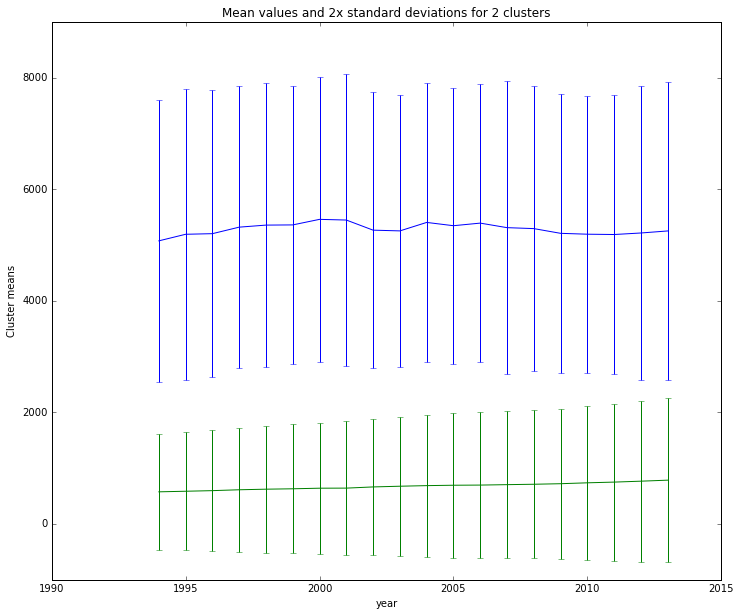

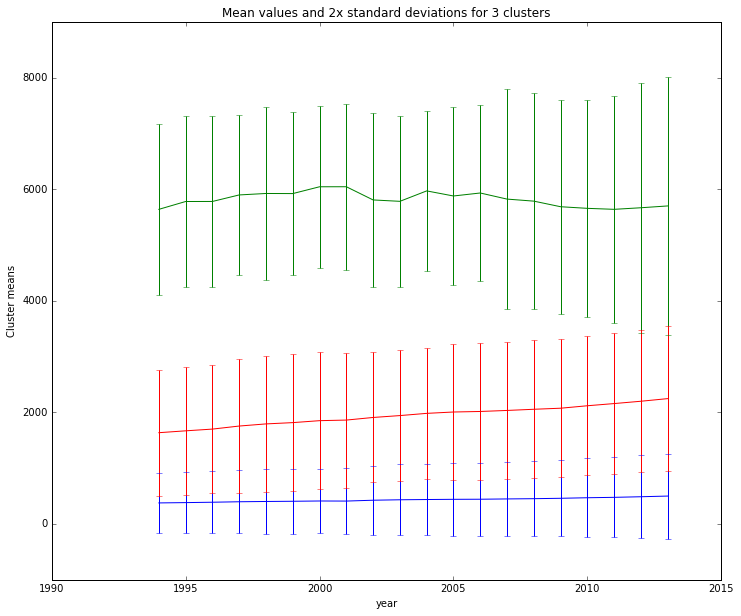

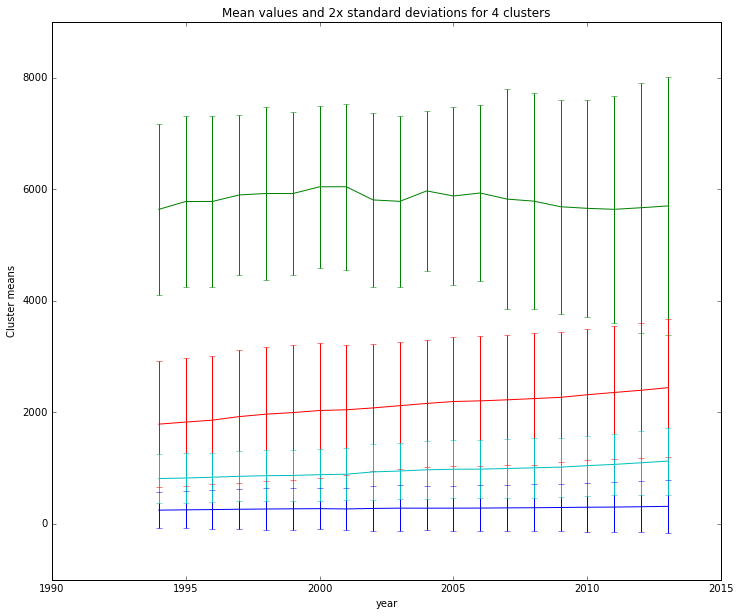

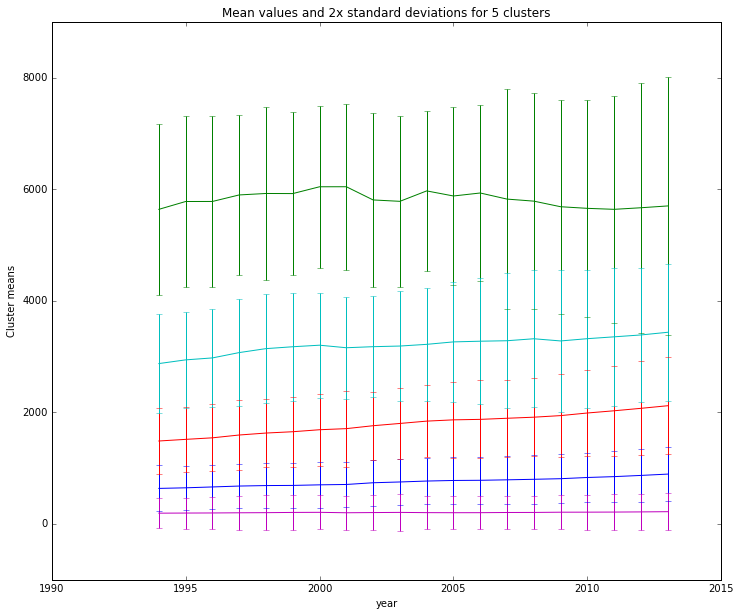

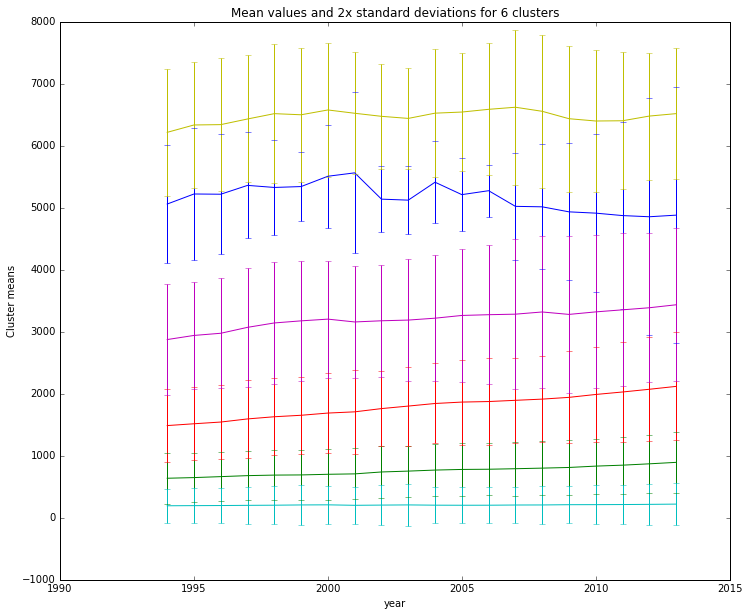

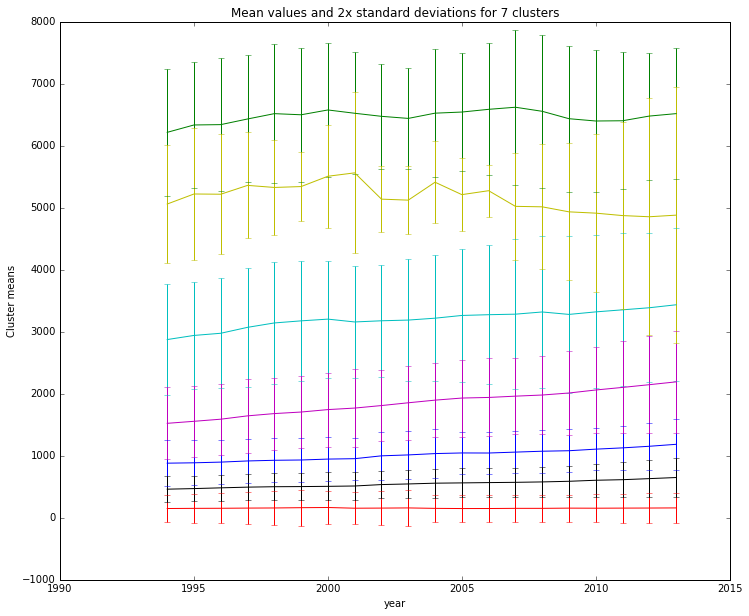

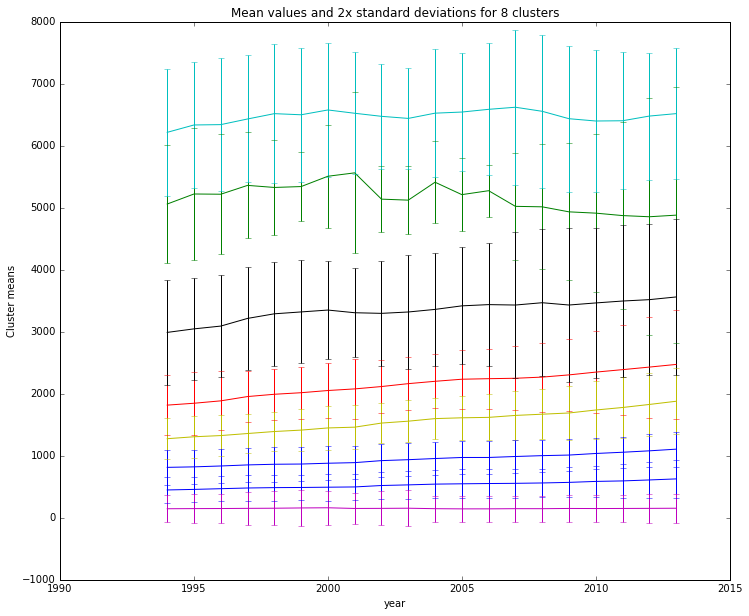

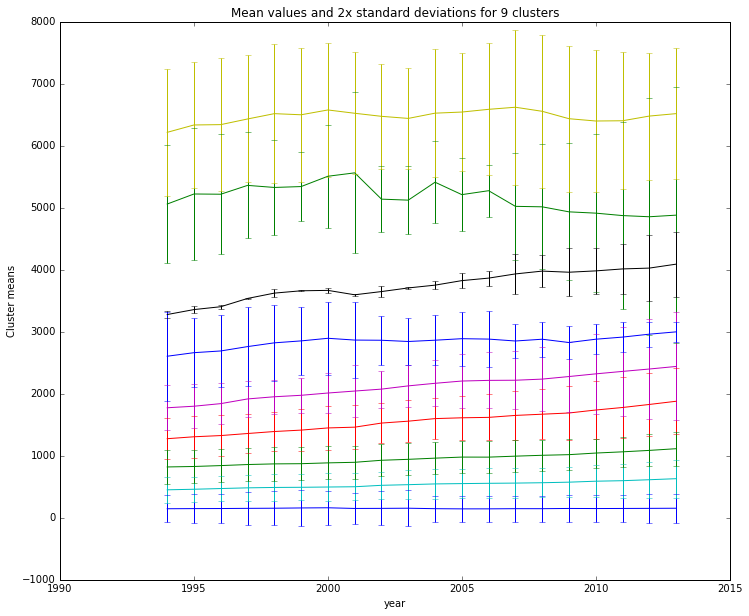

In [135]:
# graph mean | std of clusters over time to see differences
years = np.arange(1994, 2014)
for i, c in enumerate(clustN):#clustN:
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    for k in range(1, c+1):
        #print 'i = %s | c = %s | k = %s' % (i, c, k)
        #print 'means[i][k-1] shape = %s | years shape = %s' % (means[i][k-1].shape, years.shape)
        axTitle = 'Mean values and 2x standard deviations for %s clusters' % c
        ax.set_title(axTitle) 
        ax.set_xlabel('year')
        ax.set_ylabel('Cluster means')
        ax.errorbar(years, means[i][k-1], yerr=stdevs[i][k-1]*2)

### task 3. 
plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).

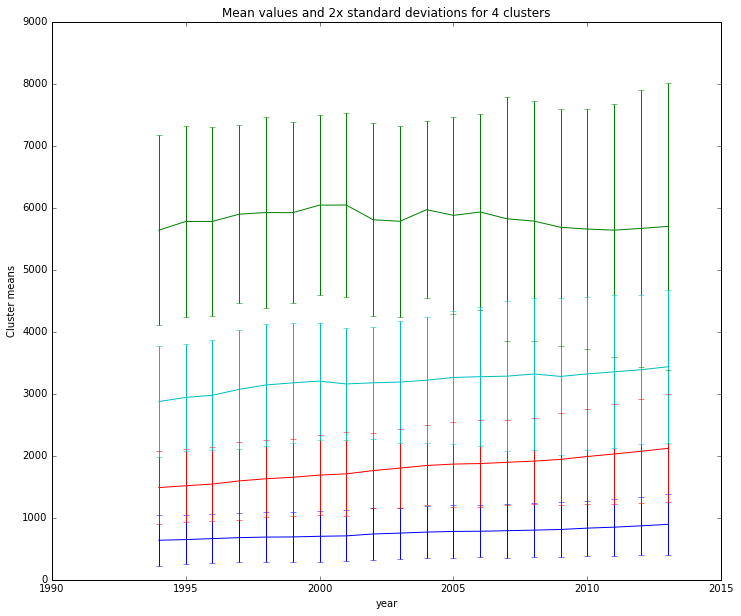

In [136]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.set_title('Mean values and 2x standard deviations for 4 clusters') 
ax.set_xlabel('year')
ax.set_ylabel('Cluster means')
for k in range(1, 5):
    ax.errorbar(years, means[3][k-1], yerr=stdevs[3][k-1]*2)

## task 4. Use another clustering algorithm (of your choice)

In [67]:
from sklearn.cluster import AgglomerativeClustering

In [137]:
aggCluster = AgglomerativeClustering(linkage='ward', n_clusters=4)
aggCluster.fit(clust_data)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=4, n_components=None,
            pooling_func=<function mean at 0x7f20e01ca2a8>)

In [138]:
est_data['aggClust4'] = aggCluster.labels_
aggMeans = est_data.groupby('aggClust4')[yrs].mean().values
aggStDevs = est_data.groupby('aggClust4')[yrs].std().values

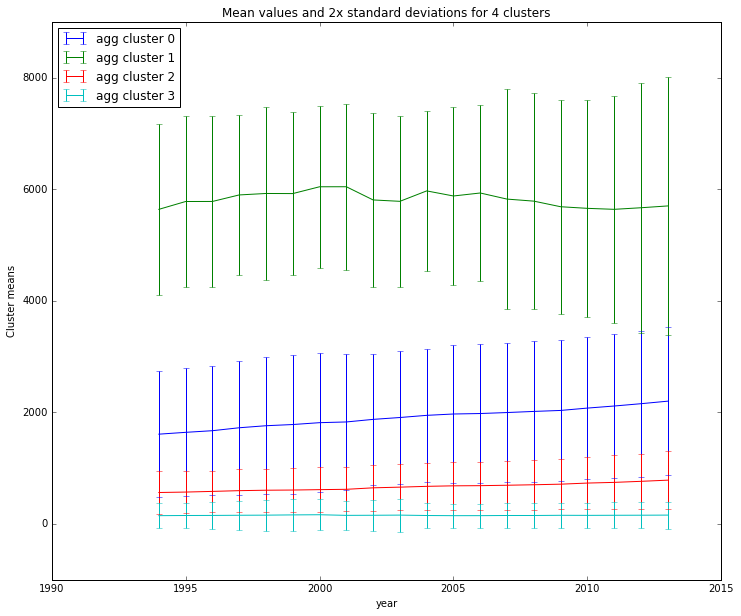

In [155]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.set_title('Mean values and 2x standard deviations for 4 clusters') 
ax.set_xlabel('year')
ax.set_ylabel('Cluster means')
for k in range(4):
    aggLab = 'agg cluster %s' % k
    ax.errorbar(years, aggMeans[k], yerr=aggStDevs[k]*2, label=aggLab)
    
ax.legend(loc='best')

## task 5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters

In [78]:
zipcodes.head()

,cty_fips,objectid,po_name,shape_area,borough,geometry,postalcode,zipnum
0,081,1,Jackson Heights,20163283.87440,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,11372
1,081,2,Glen Oaks,22606526.91390,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,11004
2,081,3,New Hyde Park,6269333.41234,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,11040
3,081,4,Bellerose,49418364.05770,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,11426
4,081,5,Fresh Meadows,69385865.59430,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,11365


In [140]:
est_data.loc[:,('aggClust4', 'cluster_4')].info()

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 10001 to 11697
Data columns (total 2 columns):
aggClust4    230 non-null int64
cluster_4    230 non-null int32
dtypes: int32(1), int64(1)
memory usage: 4.5+ KB


In [141]:
mapData = pd.merge(zipcodes, est_data.loc[:,('aggClust4', 'cluster_4')], left_on='postalcode', right_index=True)
mapData.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 243 entries, 0 to 261
Data columns (total 10 columns):
cty_fips      243 non-null object
objectid      243 non-null int64
po_name       243 non-null object
shape_area    243 non-null float64
borough       243 non-null object
geometry      243 non-null object
postalcode    243 non-null object
zipnum        243 non-null int64
aggClust4     243 non-null int64
cluster_4     243 non-null int32
dtypes: float64(1), int32(1), int64(3), object(5)
memory usage: 19.9+ KB


Agglomerative clustering


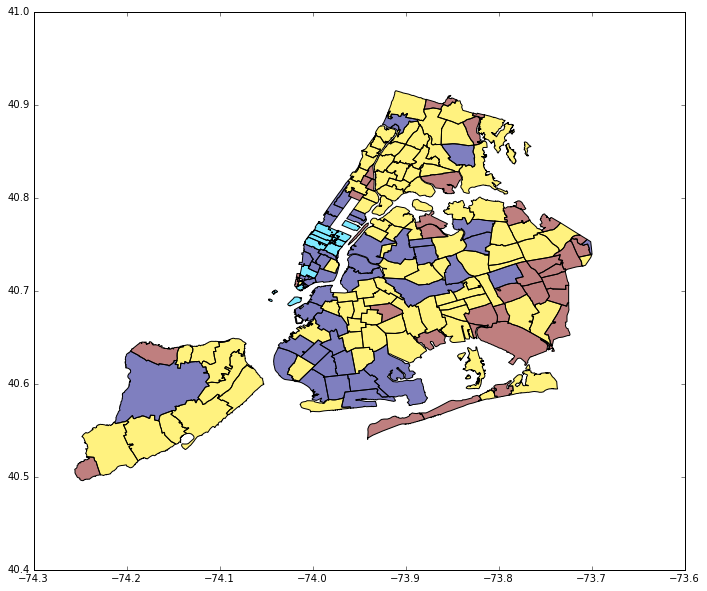

In [142]:
print 'Agglomerative clustering'
mapData.plot('aggClust4', figsize=(12,10))
#mpl.display()

K-means clustering


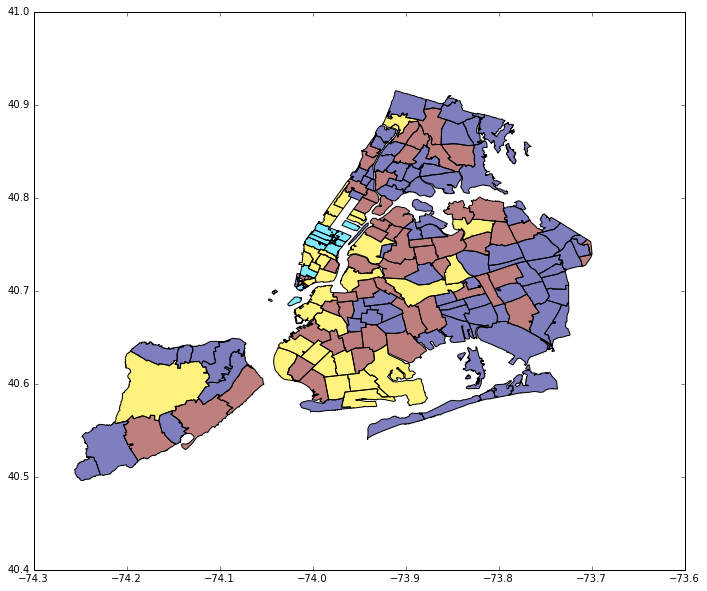

In [143]:
print 'K-means clustering'
mapData.plot('cluster_4', figsize=(12,10))
#mpl.display()

## task 6. Compare the results of the 2 algorithms

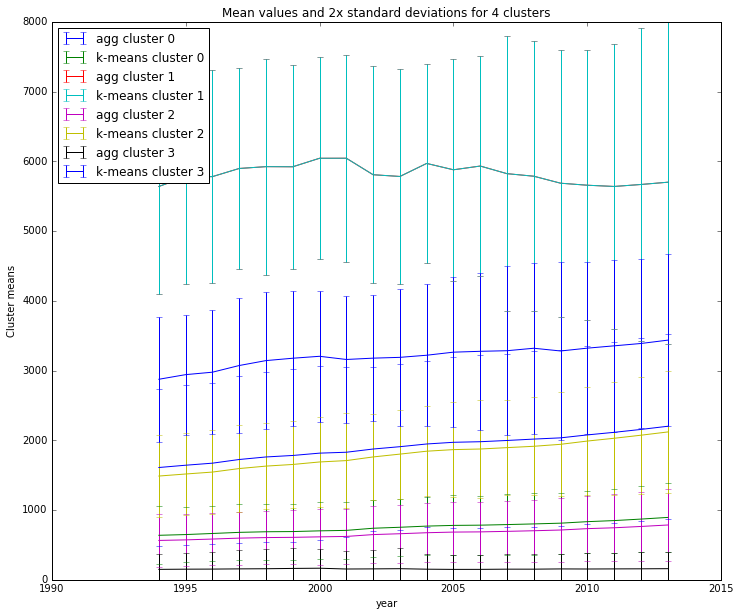

In [158]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.set_title('Mean values and 2x standard deviations for 4 clusters') 
ax.set_xlabel('year')
ax.set_ylabel('Cluster means')
ax.set_ylim(0, 8000)
for k in range(4):
    aggLab = 'agg cluster %s' % k
    kmLab = 'k-means cluster %s' % k
    ax.errorbar(years, aggMeans[k], yerr=aggStDevs[k]*2, label=aggLab)
    ax.errorbar(years, means[3][k], yerr=stdevs[3][k]*2, label=kmLab)
    
ax.legend(loc='best')

In [146]:
est_data.groupby(['cluster_4', 'aggClust4'])[yrs].agg(['count', 'sum', 'mean', 'std'])

1994                                  1995         \
                    count    sum         mean         std count    sum   
cluster_4 aggClust4                                                      
0         2            49  20346   415.224490   74.030755    49  20855   
          3            83  12421   149.650602  111.619392    83  12643   
1         1            10  56390  5639.000000  767.677450    10  57794   
2         0            31  55485  1789.838710  564.923776    31  56609   
3         0            12  13741  1145.083333  144.368505    12  14025   
          2            45  32706   726.800000  141.987131    45  32943   

                                              1996            ...       \
                            mean         std count    sum     ...        
cluster_4 aggClust4                                           ...        
0         2           425.612245   66.919360    49  21345     ...        
          3           152.325301  115.998645    83  12747     ...        
1         1          5779.400000  766.608722    10  57803     ...        
2         0          1826.096774  572.647789    31  57694     ...        
3         0          1168.750000  133.282424    12  14205     ...        
          2           732.066667  136.782242    45  33579     ...        

                            2011               2012                      \
                            mean          std count    sum         mean   
cluster_4 aggClust4                                                       
0         2           552.530612   100.644196    49  27775   566.836735   
          3           156.313253   116.159891    83  13070   157.469880   
1         1          5639.300000  1019.180504    10  56676  5667.600000   
2         0          2357.258065   594.647176    31  74278  2396.064516   
3         0          1486.916667   200.460587    12  18421  1535.083333   
          2           956.511111   159.161671    45  44110   980.222222   

                                  2013                                   
                             std count    sum         mean          std  
cluster_4 aggClust4                                                      
0         2           106.743530    49  28531   582.265306   111.841923  
          3           118.873507    83  13239   159.506024   121.089603  
1         1          1120.147232    10  57001  5700.100000  1158.025182  
2         0           605.496872    31  75729  2442.870968   618.191866  
3         0           222.991014    12  18925  1577.083333   237.208178  
          2           166.435066    45  45319  1007.088889   174.639736  

[6 rows x 80 columns]

In [157]:
est_data.groupby(['cluster_4'])[yrs].agg(['count', 'mean', 'std'])

1994                           1995                           1996  \
          count         mean         std count         mean         std count   
cluster_4                                                                       
0           132   248.234848  162.465539   132   253.772727  166.220519   132   
1            10  5639.000000  767.677450    10  5779.400000  766.608722    10   
2            31  1789.838710  564.923776    31  1826.096774  572.647789    31   
3            57   814.859649  222.559979    57   824.000000  224.609900    57   

                                    1997     ...             2010  2011  \
                  mean         std count     ...              std count   
cluster_4                                    ...                          
0           258.272727  171.390946   132     ...       219.017824   132   
1          5780.300000  762.431206    10     ...       969.667463    10   
2          1861.096774  574.908477    31     ...       585.491627    31   
3           838.315789  220.389198    57     ...       269.268786    57   

                                     2012                            2013  \
                  mean          std count         mean          std count   
cluster_4                                                                   
0           303.393939   221.541124   132   309.431818   228.986056   132   
1          5639.300000  1019.180504    10  5667.600000  1120.147232    10   
2          2357.258065   594.647176    31  2396.064516   605.496872    31   
3          1068.175439   274.573964    57  1097.035088   289.163632    57   

                                     
                  mean          std  
cluster_4                            
0           316.439394   236.213652  
1          5700.100000  1158.025182  
2          2442.870968   618.191866  
3          1127.087719   299.965550  

[4 rows x 60 columns]

In [156]:
est_data.groupby(['aggClust4'])[yrs].agg(['count', 'mean', 'std'])

1994                           1995                           1996  \
          count         mean         std count         mean         std count   
aggClust4                                                                       
0            43  1609.906977  564.838823    43  1642.651163  572.616795    43   
1            10  5639.000000  767.677450    10  5779.400000  766.608722    10   
2            94   564.382979  191.972058    94   572.319149  186.684612    94   
3            83   149.650602  111.619392    83   152.325301  115.998645    83   

                                    1997     ...             2010  2011  \
                  mean         std count     ...              std count   
aggClust4                                    ...                          
0          1672.069767  577.608056    43     ...       636.982901    43   
1          5780.300000  762.431206    10     ...       969.667463    10   
2           584.297872  187.165319    94     ...       232.861102    94   
3           153.578313  119.998589    83     ...       114.059040    83   

                                     2012                            2013  \
                  mean          std count         mean          std count   
aggClust4                                                                   
0          2114.372093   647.401253    43  2155.790698   653.903610    43   
1          5639.300000  1019.180504    10  5667.600000  1120.147232    10   
2           745.925532   241.614028    94   764.734043   249.177882    94   
3           156.313253   116.159891    83   157.469880   118.873507    83   

                                     
                  mean          std  
aggClust4                            
0          2201.255814   664.912994  
1          5700.100000  1158.025182  
2           785.638298   257.695655  
3           159.506024   121.089603  

[4 rows x 60 columns]

> K-means and agglomerative clustering have 
1. similar results: both creating the same cluster #1 of 10 zipcodes in Manhattan (mainly midtown) with the most businesses, two groups with increasing businesses (one both starting with and adding more businesses), and a group with the least number of businesses that stays about the same level throughout
2. different results: the 'other' 3 clusters (not cluster #1) each have an overlapping mix of zipcodes, but agglomerative clustering appears to slightly better group the lowest number of business zipcodes as it has both a lower mean and smaller standard deviation across the years

## task 7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 

> 1. There seems to be a core business district (cluster 1) as both clustering methods identify the same group of zipcoes with the highest business concentrations,
2. Business growth across NYC has been primarily outside of that core business district (although I would also want to look at corresponding numbers of employees and ideally revenue generated), and
3. Roughly 1/3 of zipcodes across NYC have way fewer businesses and have not seen any growth in businesses suggesting they may be more residential